# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

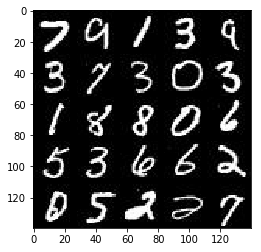

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

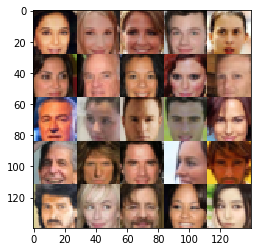

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None,image_width, image_height, image_channels], name='input_real' )
    z_input = tf.placeholder(tf.float32,[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        con1 = tf.layers.conv2d(images, 32, 5, strides=2, padding="same")
        le1 = tf.maximum(0.2*con1, con1)
        #14*14*32
        
        con2 = tf.layers.conv2d(le1, 64, 5, 2, padding="same")
        ln2 = tf.layers.batch_normalization(con2,training=True)
        le2 = tf.maximum(0.2*ln2, ln2)
        #7*7*64
        
        con3 = tf.layers.conv2d(le2, 128, 5, 2, padding="same")
        #print(con3.get_shape().as_list())
        ln3 = tf.layers.batch_normalization(con3,training=True)
        le3 = tf.maximum(0.2*ln3, ln3)
        #7*7*128 if i used 128,3,2 shape：7/2 = 4
        
        fl = tf.reshape(le3,(-1,4*4*128))
        logist = tf.layers.dense(fl,1)
        output = tf.sigmoid(logist)
        
        

    return output, logist


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        flat = tf.layers.dense(z,4*4*128)       
        x1 = tf.reshape(flat,(-1,4,4,128))
        ln1 = tf.layers.batch_normalization(x1,training=is_train)
        le1 = tf.maximum(0.2*ln1, ln1)
        # 4*4*128
        
        x2 = tf.layers.conv2d_transpose(le1, 64, 4, strides=1, padding='valid')
        #print(x2.get_shape().as_list())
        ln2 = tf.layers.batch_normalization(x2, training=is_train)
        le2 = tf.maximum(0.2*ln2, ln2)
        #8*8*64 can't transport to 28 how?
        
        x3 = tf.layers.conv2d_transpose(le2, 32, 5, strides=2, padding='same')        
        ln3 = tf.layers.batch_normalization(x3, training=is_train)
        le3 = tf.maximum(0.2*ln3, ln3)
        #16*16*32
        
        x4 = tf.layers.conv2d_transpose(le3, out_channel_dim, 5, strides=2, padding='same')        
        #32*32*3
        
        output = tf.tanh(x4)
        #output = tf.div(output, 2) #转换成 -0.5 0.5
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    output_z = generator(input_z, out_channel_dim, is_train=True)
    _ ,logits =  discriminator(input_real, reuse=False)
    _ ,logits_z =  discriminator(output_z, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.ones_like(logits)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_z, labels=tf.zeros_like(logits_z)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_z, labels=tf.ones_like(logits_z)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_var = tf.trainable_variables()
    g_var = [var for var in train_var if var.name.startswith('generator')]
    d_var = [var for var in train_var if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt =  tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_opt =  tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model   
    input_real, input_z, learning_rate_p = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model        
                #print(learning_rate,learning_rate_p)
                step += 1
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                #print(batch_images)                
                batch_images = 2.0*batch_images
                #print(batch_images)
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_p:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_p:learning_rate})
                train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, learning_rate_p:learning_rate})
                train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, learning_rate_p:learning_rate})                
                if step%100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                if step%10 ==0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5244... Generator Loss: 4.2191
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 4.0962
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 5.4302
Epoch 1/2... Discriminator Loss: 0.2794... Generator Loss: 1.9470
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 1.3097
Epoch 1/2... Discriminator Loss: 1.8120... Generator Loss: 0.3722
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.6061


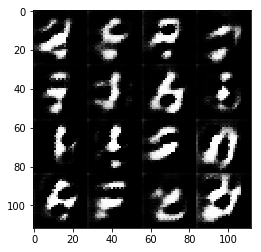

Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.5662
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.3551
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 1.6578
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 0.8087... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 1.8313
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 3.0800
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.9826


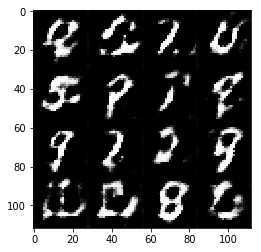

Epoch 1/2... Discriminator Loss: 2.0698... Generator Loss: 3.3349
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.3802
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 2.7549
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 0.9390
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 1.5856


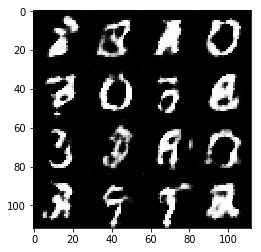

Epoch 1/2... Discriminator Loss: 1.8217... Generator Loss: 2.9309
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.6951... Generator Loss: 0.3152
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.4276
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.4931
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 1.0221


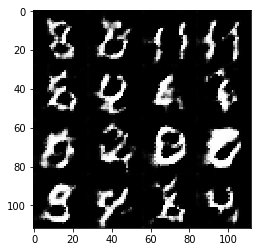

Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 1.3581
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.4274
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.4100
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.7581


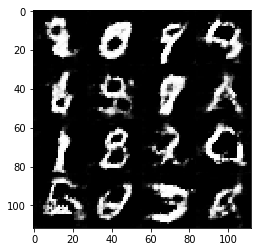

Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.7809... Generator Loss: 0.3114
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.2523
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.1472
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.6307


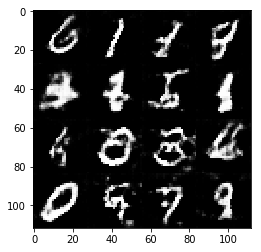

Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 2.0781
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.3564
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.1112... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.9201


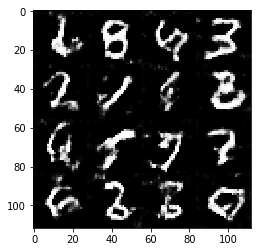

Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 0.9903... Generator Loss: 0.8284
Epoch 1/2... Discriminator Loss: 1.7245... Generator Loss: 0.3157
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 1.3900
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.8831
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.4621
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.4585


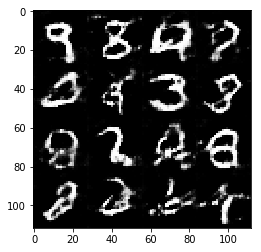

Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.0029
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 2.3235
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.4467
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.9954
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 2.4668
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 1.9961
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.5568... Generator Loss: 0.3534


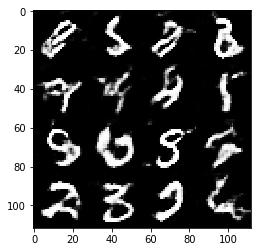

Epoch 1/2... Discriminator Loss: 0.7254... Generator Loss: 1.2718
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 2.3408
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 1.2265
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 2.0127
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 0.7324... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 2.5248
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.0094
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.5468


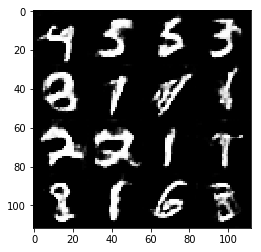

Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 1.3456
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 0.7944
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 1.3936
Epoch 2/2... Discriminator Loss: 2.0539... Generator Loss: 0.2204


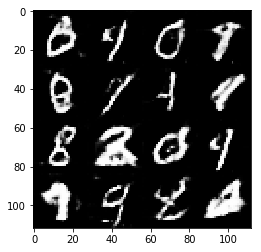

Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.7513
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.5235
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 3.1214
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.0678
Epoch 2/2... Discriminator Loss: 0.6986... Generator Loss: 1.9488
Epoch 2/2... Discriminator Loss: 1.7235... Generator Loss: 0.3292


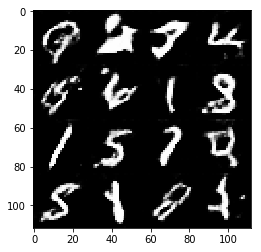

Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.4479
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 1.6471
Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 0.5981... Generator Loss: 2.6146
Epoch 2/2... Discriminator Loss: 1.7920... Generator Loss: 0.2940
Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 1.5929
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 0.8135


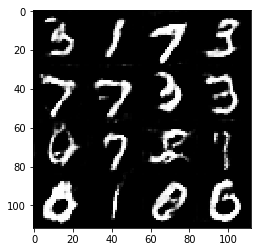

Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 2.6270
Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.6412... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 0.6209... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 3.1355
Epoch 2/2... Discriminator Loss: 3.0715... Generator Loss: 0.1468
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 2.0455
Epoch 2/2... Discriminator Loss: 0.4961... Generator Loss: 1.8549
Epoch 2/2... Discriminator Loss: 1.5593... Generator Loss: 3.7173
Epoch 2/2... Discriminator Loss: 0.6052... Generator Loss: 1.4775


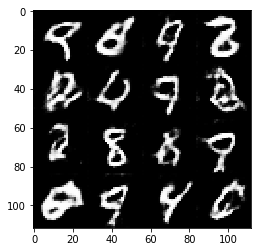

Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.5417
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.5638
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 2.2576
Epoch 2/2... Discriminator Loss: 1.7079... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.5976
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.0856
Epoch 2/2... Discriminator Loss: 0.4913... Generator Loss: 1.3532
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.4023
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 1.6091


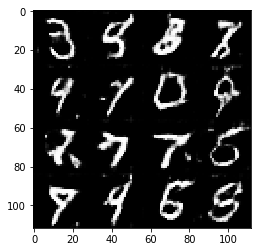

Epoch 2/2... Discriminator Loss: 0.2695... Generator Loss: 1.9228
Epoch 2/2... Discriminator Loss: 0.8369... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.5338
Epoch 2/2... Discriminator Loss: 1.4729... Generator Loss: 2.2991
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 1.0068
Epoch 2/2... Discriminator Loss: 0.7571... Generator Loss: 1.6727
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 0.7444... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 0.9541


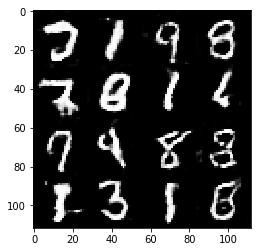

Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.8788... Generator Loss: 0.3012
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 0.5827... Generator Loss: 1.2149
Epoch 2/2... Discriminator Loss: 0.3874... Generator Loss: 2.0579
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.7196
Epoch 2/2... Discriminator Loss: 0.3692... Generator Loss: 1.6793
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 1.0110
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 2.2635... Generator Loss: 0.2299


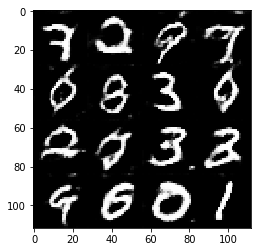

Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.3686
Epoch 2/2... Discriminator Loss: 2.4232... Generator Loss: 0.2093
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 1.5143
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 2.8982
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 4.0177
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 1.0563
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 3.3002


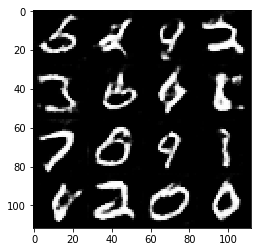

Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 1.4528... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 0.4737... Generator Loss: 1.7623
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 0.7741


In [46]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 13.7505
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 3.3139
Epoch 1/1... Discriminator Loss: 0.0601... Generator Loss: 13.2181
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 2.4786
Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 8.1229
Epoch 1/1... Discriminator Loss: 0.0324... Generator Loss: 4.0798
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 5.7891
Epoch 1/1... Discriminator Loss: 0.2143... Generator Loss: 4.0501


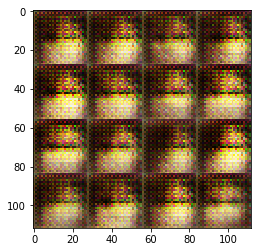

Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 2.7358
Epoch 1/1... Discriminator Loss: 0.2844... Generator Loss: 9.3948
Epoch 1/1... Discriminator Loss: 0.1850... Generator Loss: 3.7896
Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 3.0855
Epoch 1/1... Discriminator Loss: 0.1842... Generator Loss: 2.8786
Epoch 1/1... Discriminator Loss: 0.2418... Generator Loss: 3.4312
Epoch 1/1... Discriminator Loss: 0.0907... Generator Loss: 4.2218
Epoch 1/1... Discriminator Loss: 0.3125... Generator Loss: 2.8703
Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 6.1154
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.1727


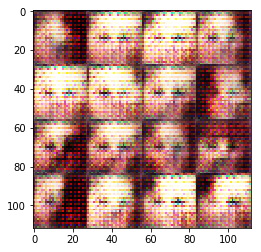

Epoch 1/1... Discriminator Loss: 0.1493... Generator Loss: 2.6468
Epoch 1/1... Discriminator Loss: 0.2076... Generator Loss: 2.9055
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 11.8219
Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 3.5649
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 2.0173
Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 2.3064
Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 5.5803
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 1.6422
Epoch 1/1... Discriminator Loss: 0.2299... Generator Loss: 2.9140
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 1.5610


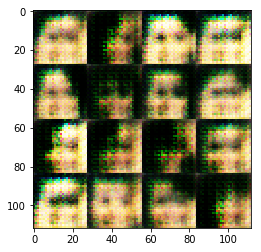

Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.5121
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.1556... Generator Loss: 4.0672
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 3.6705
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 4.6986
Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 2.9560
Epoch 1/1... Discriminator Loss: 0.1749... Generator Loss: 2.9364
Epoch 1/1... Discriminator Loss: 0.2673... Generator Loss: 2.4914
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 1.2425


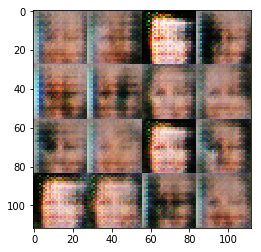

Epoch 1/1... Discriminator Loss: 0.3198... Generator Loss: 2.1291
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 2.6332
Epoch 1/1... Discriminator Loss: 0.2320... Generator Loss: 2.5128
Epoch 1/1... Discriminator Loss: 0.5092... Generator Loss: 4.1492
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 3.0710
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.4826
Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 2.8896
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 3.0918


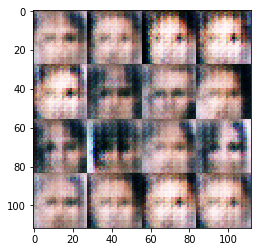

Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 4.6079
Epoch 1/1... Discriminator Loss: 0.3252... Generator Loss: 3.0984
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 1.6350
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 2.3103
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.3878
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.7559
Epoch 1/1... Discriminator Loss: 0.4635... Generator Loss: 2.1068
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 2.9395


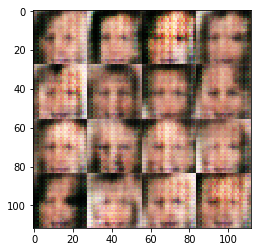

Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.7944
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 2.1391
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.9804
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.8828
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 2.0479
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 1.6104
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.3547


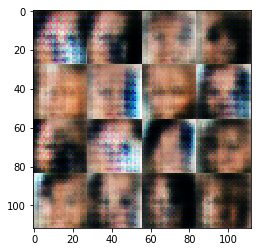

Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 2.4737
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 2.6245
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 2.3438
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 1.8044
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 1.4807
Epoch 1/1... Discriminator Loss: 0.2507... Generator Loss: 2.6109


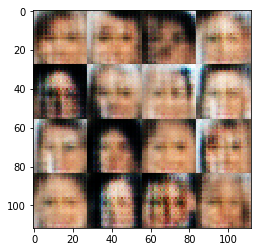

Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 2.4767
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 3.3948
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 3.6126
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 0.2126... Generator Loss: 2.4967
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 2.5538
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 3.3772
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 2.2271


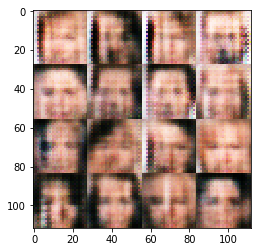

Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 2.4261
Epoch 1/1... Discriminator Loss: 0.6189... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 1.5420
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.4488
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 2.1280
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 3.6954
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 2.3323


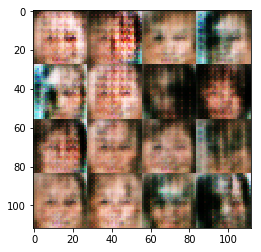

Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 2.0310
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 3.3535
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 2.1511
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 2.7475
Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.9088
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.9737
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 2.6604
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 2.7265
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 1.8769


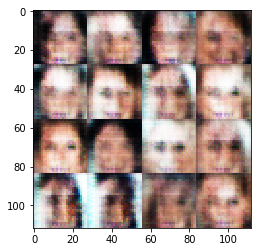

Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 3.1275
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 1.6351
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 2.2267
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.5748
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 2.0254
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 3.2258
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 2.8849


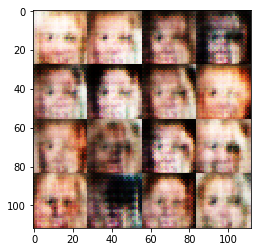

Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 2.0112
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 2.5196
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.8449
Epoch 1/1... Discriminator Loss: 0.3184... Generator Loss: 2.7187
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.4357
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.0138


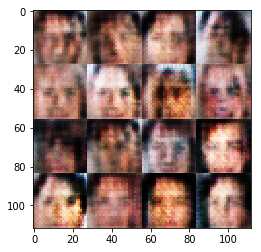

Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 2.1627
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 2.5153
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.0982
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 2.6541
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.2489
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 3.2797
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 3.1284


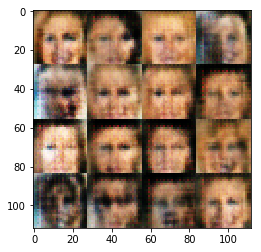

Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 2.3405
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.9251
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 2.1447


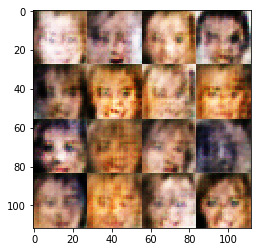

Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.6863
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.9410
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.3716


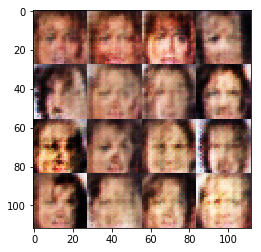

Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 2.4600
Epoch 1/1... Discriminator Loss: 0.5317... Generator Loss: 1.6435
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 2.0009
Epoch 1/1... Discriminator Loss: 0.4679... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 2.0061
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.5299
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 2.3521
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 2.3289


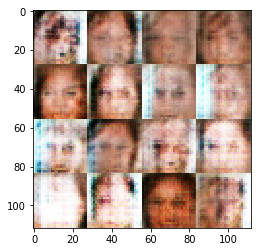

Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 1.4928
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 2.1758
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 2.5004
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 3.0435
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 3.4352
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 2.3249
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 2.0980
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.9347


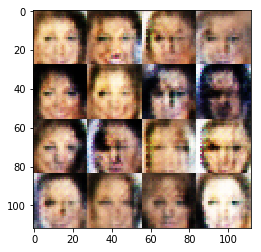

Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 1.9374
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.8543
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 2.8133
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 2.7831
Epoch 1/1... Discriminator Loss: 2.6415... Generator Loss: 0.1725
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.9693


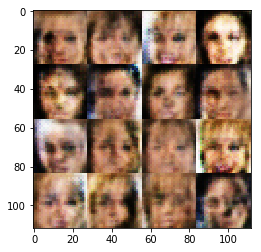

Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 2.2736
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 2.1230
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 0.5649... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.4952
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 1.9437
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.8668


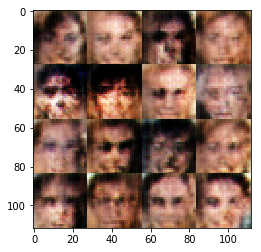

Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 3.2835
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.7258
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.7805
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.4941
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 2.3025
Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 1.8647


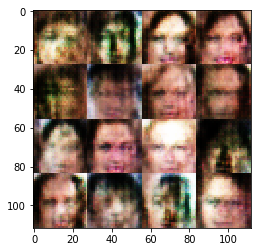

Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 2.2041
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 2.7326
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.6637
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 1.9880
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 2.4939
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.1182
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.7506
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 2.2975


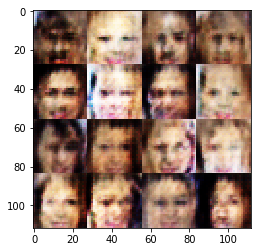

Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 1.8419
Epoch 1/1... Discriminator Loss: 0.3017... Generator Loss: 2.9013
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.6766
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 2.9254
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 3.1209


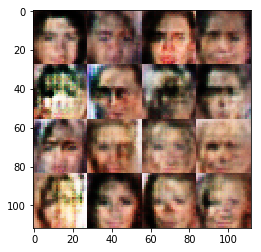

Epoch 1/1... Discriminator Loss: 0.2876... Generator Loss: 2.8340
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.0574
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.0757
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.4958
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 2.9397
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.6696
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8490


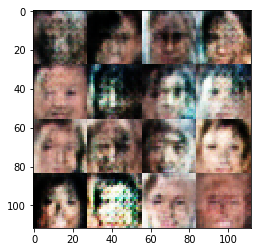

Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.2718
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.9678
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.4746
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.4640


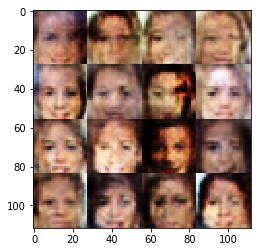

Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 2.6135
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 2.3123
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 3.1105
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.2119
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 1.9334
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.8921


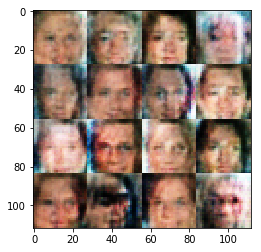

Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.5811
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 2.0590
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.1870


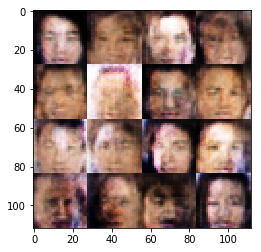

Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.9634
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 2.3631
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 2.0786
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.6469... Generator Loss: 1.8114
Epoch 1/1... Discriminator Loss: 0.5992... Generator Loss: 1.4540
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.9388
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 2.2514


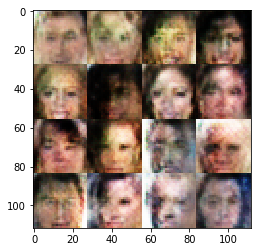

Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 2.0048
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 2.1368
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 2.3571
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 2.2722
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 1.9628


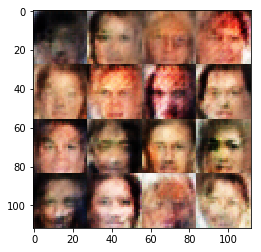

Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 1.9575
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.7090
Epoch 1/1... Discriminator Loss: 0.6243... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 0.2615... Generator Loss: 2.8663
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 1.4656


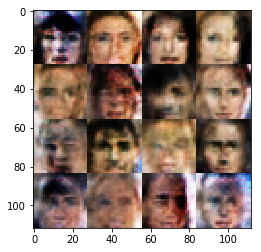

Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.1471
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.7424
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.0680
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 1.9738
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 2.1719
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.3305
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.4974
Epoch 1/1... Discriminator Loss: 0.8388... Generator Loss: 2.1119


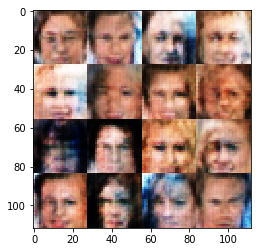

Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.6979
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 2.3889
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 2.4116
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 2.1314
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 1.7393
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.8109


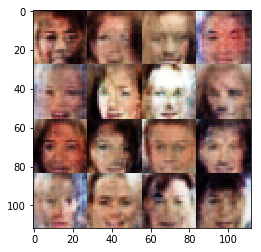

Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 2.3431
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 2.0078
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.8307
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.3111


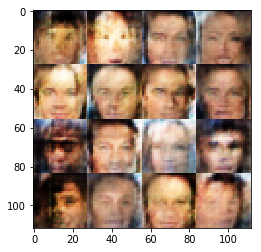

Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 0.9549... Generator Loss: 2.7204
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 2.9835
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 1.7625
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.8434
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 2.2288


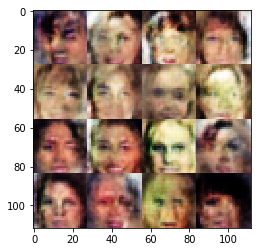

Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 2.0686
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.9696
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 2.1570


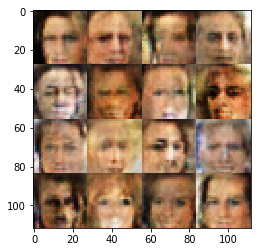

Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.7922
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.4626
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.3395
Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.7605... Generator Loss: 2.0142
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.0460
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.0673


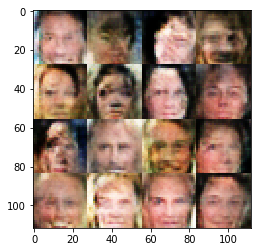

Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.5307
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 1.8720
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.6853


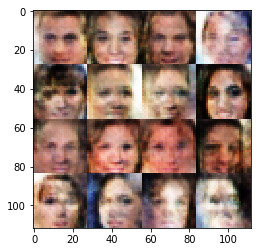

Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 2.1596
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 2.1806
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.1619


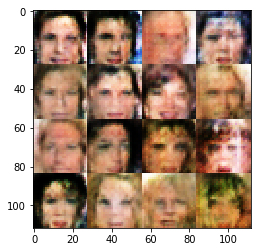

Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 1.6975
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.5038


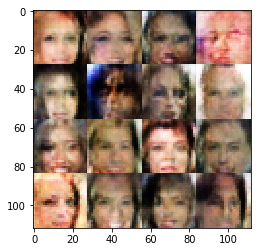

Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.2170
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.7124
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.7288
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 0.5041... Generator Loss: 2.6062
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 2.1484
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.5046


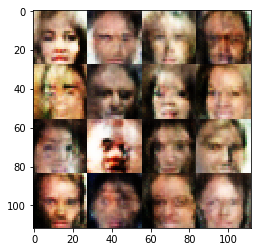

Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.6541
Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 3.2363
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.7333
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.5674


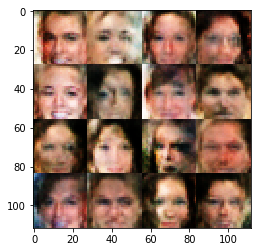

Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 0.6243... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.4977
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.6702


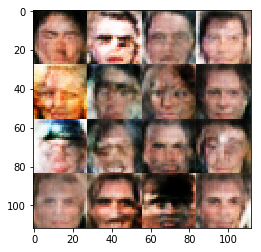

Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.9563
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 2.1171
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.9200
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.4100
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.1085


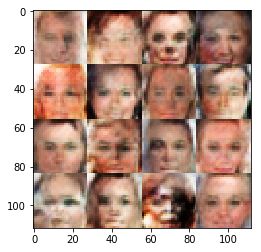

Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 1.7448
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 2.0065
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.5188


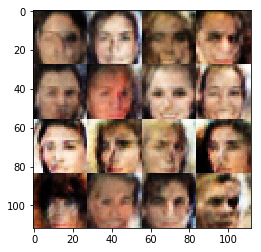

Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.2841
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 1.7134
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 2.2493
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 2.2162
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.0251


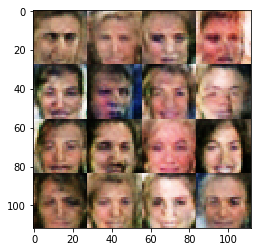

Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.2730
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.7970
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.2582


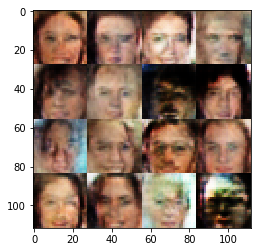

Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 2.2138
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.9291... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.7812
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.5604


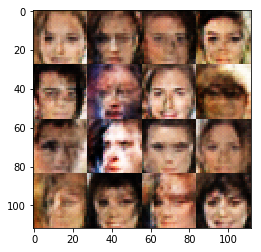

Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.8968
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.4278


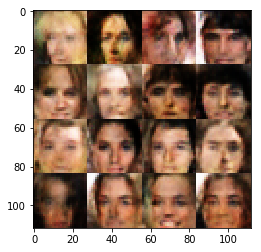

Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 2.1222
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.0943
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.4618
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 1.8297
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 2.5902
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 2.0694


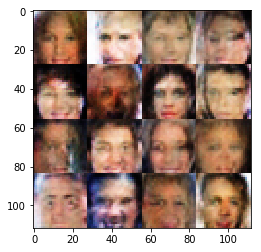

Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.5639
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.7367


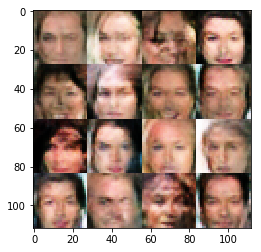

Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.9726
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.9016
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.8380
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 2.6942
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.3632


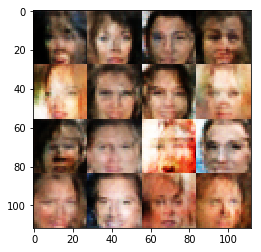

Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.6828
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 2.2106
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.8834


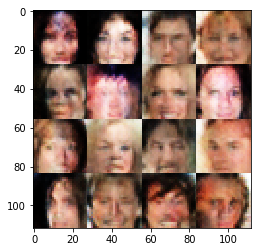

Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.4854
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 2.1252
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.5266
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 2.1101
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.5021


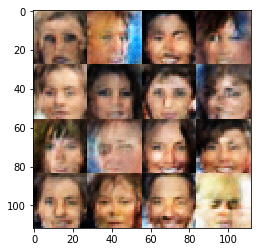

Epoch 1/1... Discriminator Loss: 0.3028... Generator Loss: 2.2948
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.8523... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.5915
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.9851
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 1.5701


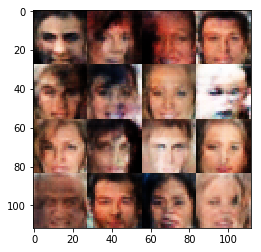

Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 1.6819
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.6191
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 2.1139
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.8814


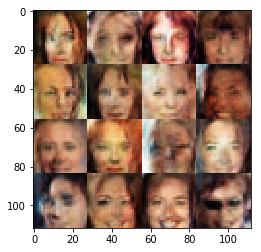

Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 2.1607
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 1.5880
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.4352
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.6813
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.0978


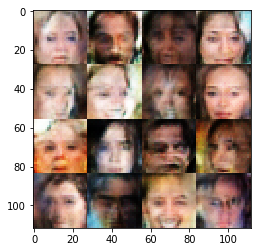

Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.1904
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.8873
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 1.8115
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.3388


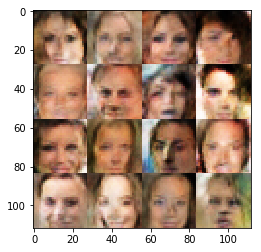

Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.0882
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 2.5488
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 0.8680


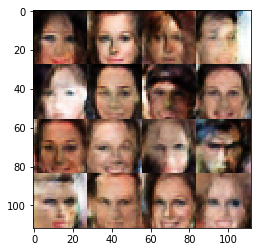

Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.5782
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.7359
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6240


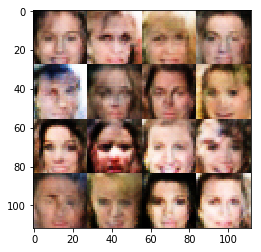

Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.7085
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 2.4839
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.6995... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.0271


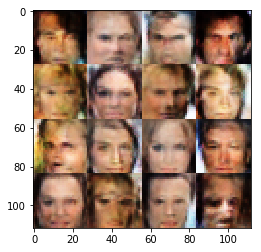

Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.7489
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 1.7413
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.7482
Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.5951
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.4037
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.0835


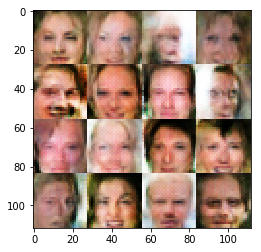

Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 2.0109
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 2.1889
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.9971


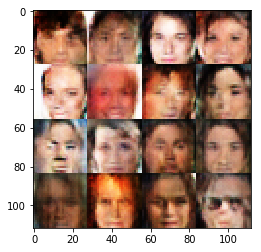

Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.6264
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.1041
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.6745
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 1.7882
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.5215


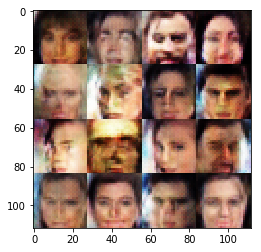

Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 2.3378


In [47]:
batch_size = 32
z_dim = 150
learning_rate = 0.001
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.